In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
import pickle
import myUtils
import os
import csv
import matplotlib.pyplot as plt
from myUtils import *
from models.utils import *
from score import ScoreUtils
from models.dataset_loader import *
import sys
sys.path.append('models')

warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
for dataset_name in ['corona', 'toy-spam', 'home-spam', 'dilemma']:
    ds_max_len = 200
    model_type = 'deberta'
    #model_type = 'tinybert'
    model_name = 'microsoft/deberta-v3-small'
    #model_name = 'huawei-noah/TinyBERT_General_4L_312D'
    sorting = 'confidence'
    model = load_model(f'models/{model_type}/{dataset_name}/model').to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
    mlm_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=False)
    #mlm_tokenizer = spacy.load('en_core_web_sm')  
    myUtils.model = model
    myUtils.tokenizer = tokenizer
    
    for seed in [42, 84, 126, 168, 210]:
        for delta in [0.1, 0.15, 0.2, 0.35, 0.5]:
            for opt in [None, 'topk', 'desired', 'masking', 'desired-masking', 'stop-words', 'stop-words-topk', 'stop-words-masking', 'stop-words-desired', 'stop-words-topk-masking', 'stop-words-topk-desired-masking']:
                cur_opt = delta if opt is None else f'{opt}-{delta}'
                folder_name = f'results/mp/{model_type}/{dataset_name}/{sorting}/{seed}/{cur_opt}'    

                exps = pickle.load(open(f"{folder_name}/exps_list.pickle", "rb"))
                #exps = [e for e in exps if e.precision >=0.95]
                anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
                print(f'anchor examples len: {len(anchor_examples)}')
                print(f'exps len: {len(exps)}')

                if not os.path.exists(f"{folder_name}/predictions.pickle"):
                    predictions = [predict_sentences([example])[0] for example in anchor_examples]
                    pickle.dump(predictions, open(f"{folder_name}/predictions.pickle", "wb" ))

                labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
                ScoreUtils.calculate_agg_score(folder_name, mlm_tokenizer, anchor_examples, exps, labels, 'root')
                ScoreUtils.calculate_agg_score(folder_name, mlm_tokenizer, anchor_examples, exps, labels, 'homogenity')
                
                ScoreUtils.calculate_scores(f'{folder_name}/scores.xlsx', mlm_tokenizer, anchor_examples, exps, labels)
                
                """ calculate avg / sum aggragation types """
                for min_count in [0, 2e-3, 3e-3, 4e-3]:
                    ScoreUtils.calculate_agg_score(folder_name, mlm_tokenizer, anchor_examples, exps, labels, 'avg', min_count)
                
                #ScoreUtils.calculate_agg_score(folder_name, mlm_tokenizer, anchor_examples, exps, labels, 'sum')
                if str(delta) != '0.1':
                    continue

                ds = get_ds(dataset_name)
                ds, true_labels = preprocess_examples(ds, ds_max_len)
                sorted_ds, true_labels = sort_confidence(ds, true_labels)
                pickle.dump(true_labels, open(f"{folder_name}/labels.pickle", "wb" ))
                print(f"{folder_name}/labels.pickle")

                os.makedirs(f'{folder_name}/percents', exist_ok = True)
                num_exps = len(exps)
                for i in [5, 10, 25, 50, 75, 100]:
                    ScoreUtils.calculate_percent_scores(folder_name, mlm_tokenizer, anchor_examples, exps, labels, i)

In [ ]:
true_labels = pickle.load(open(f"{folder_name}/labels.pickle", "rb" ))

In [10]:
sum(true_labels)/len(true_labels)

0.527986906710311

In [2]:
df = pd.read_csv('times.csv').drop_duplicates(subset = 'optimization', keep='last')

In [3]:
#df = pd.read_csv('times.csv')
df['ds'] = df['optimization'].apply(lambda x: x.split('/')[-4])
df['sec'] = df['optimization'].apply(lambda x: int(x.split('/')[-2]))
df['sort'] = df['optimization'].apply(lambda x: x.split('/')[-1])
df['t'] = df['optimization'].apply(lambda x: x.split('/')[-5])
df.sort_values(by=['t', 'ds', 'sort', 'sec']).drop(['t', 'ds', 'sort', 'sec'], axis=1).to_csv('times.csv', index = False)

In [ ]:
def modify(x):
    return x.replace('probabilistic', 'Gpr').replace('root', 'Gsq').replace('homogenity', 'Gh').replace('avg', 'Gavg')
for ds in ['corona', 'toy-spam', 'dilemma', 'home-spam']: 
    directory = f'results/mp/tinybert/{ds}/confidence/'
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            df = pd.read_csv(f, index_col = 0)
            df.rename(columns={"alpha": "α", 'delta': 'δ', 'percents-remove': 'percent'}, inplace=True)
            if 'aggregation' in df.columns:
                df['aggregation'] = df['aggregation'].apply(modify)
            df.to_csv(f, index = False)
for ds in ['corona', 'toy-spam', 'dilemma', 'home-spam']: 
    directory = f'results/mp/tinybert/{ds}/confidence/42/stop-words-tokens/'
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        replaced = f.replace('probabilistic', 'Gpr').replace('root', 'Gsq').replace('homogenity', 'Gh').replace('avg', 'Gavg')
        os.rename(f, replaced)

In [4]:
# can be sentiment/offensive/corona
dataset_name = 'toy-spam'
model_type = 'tinybert'
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
#model_name = 'microsoft/deberta-v3-small'
sorting = 'confidence'
delta = '0.1'
folder_name = f'results/mp/{model_type}/{dataset_name}/{sorting}/42/{delta}'    

In [5]:
model = load_model(f'models/{model_type}/{dataset_name}/model').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
mlm_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=False)
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
myUtils.model = model
myUtils.tokenizer = tokenizer
torch._C._jit_set_texpr_fuser_enabled(False)

In [10]:
ScoreUtils.calculate_agg_score(folder_name, mlm_tokenizer, anchor_examples, exps, labels, 'homogenity')

In [54]:
d = ScoreUtils.calculate_time_aggregation(mlm_tokenizer, anchor_examples, exps, labels, 'avg')

In [9]:
oc = get_occurences(sorted_ds)

In [12]:
oc['dull']

3

In [8]:
ds = get_ds(dataset_name)
ds, true_labels = preprocess_examples(ds, 200)
sorted_ds, true_labels = sort_confidence(ds, true_labels)

Filter:   0%|          | 0/11250 [00:00<?, ? examples/s]

In [14]:
tokenizer.tokenize('Good style')

['▁Good', '▁style']

# Loading Results

In [14]:
exps  = pickle.load(open(f"{folder_name}/exps_list.pickle", "rb" ))
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
print(f'anchor examples len: {len(anchor_examples)}')
print(f'exps len: {len(exps)}')

if not os.path.exists(f"{folder_name}/predictions.pickle"):
    predictions = [predict_sentences([tokenizer.tokenize(example)])[0] for example in anchor_examples]
    pickle.dump(predictions, open(f"{folder_name}/predictions.pickle", "wb" ))
    
predictions = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))

anchor examples len: 7000
exps len: 16914


In [6]:
import numpy as np
x = np.array([1,2,3])
np.concatenate([x, x], axis=0)

array([1, 2, 3, 1, 2, 3])

# Presenting Results

In [14]:
def intersect_df(d1, d2, top=25):
    s1 = set(d1.head(top).tolist())
    s2 = set(d2.head(top).tolist())
    return len(s1.intersection(s2))/top

def get_lines(path):
    return [line for line in csv.reader(open(path, "r"))]
    
def arrange_results(pos, neg, time, path, top=25):
    """
    separate the times of negative and positive sentences
    """
    labels = pickle.load(open(f"{folder_name}/0.1/predictions.pickle", "rb" ))
    emotion_dict = {1: pos, 0 : neg}
    new_emotion_dict = {1: [], 0: []}
    time_dict = {1: [], 0: []}
    last_time_dict = {1: 0.0, 0: 0.0}
    for i, label in enumerate(labels):
        new_emotion_dict[label].append(emotion_dict[label][i])
        if i==0:
            time_dict[label].append(time[i])
            last_time_dict[label] = time[i]
        else:
            new_time = last_time_dict[label] + time[i] - time[i-1]
            time_dict[label].append(new_time) 
            last_time_dict[label] = new_time
   
    return new_emotion_dict[1][top:], new_emotion_dict[0][top:], time_dict[1][top:], time_dict[0][top:]

def get_results(path):
    """
    returns the topk groups and times during runtime
    """
    pos_lines = get_lines(f'{path}/pos_monitor.csv')
    neg_lines = get_lines(f'{path}/neg_monitor.csv')
    time_lines = [float(line[0]) for line in get_lines(f'{path}/time_monitor.csv')] 
    pos_lines, neg_lines, pos_time, neg_time = arrange_results(pos_lines, neg_lines, time_lines, path)
    
    return pos_lines, neg_lines, pos_time, neg_time

def get_scores_dict(top=25, trail_path = "0.1/scores.xlsx", alpha = 0.95):
    """
    returns dict of (anchor, score) pairs, and sum of the topk positive/negative
    """
    
    df = pd.read_excel(f'{folder_name}/{trail_path}').drop(0)

    neg_keys = df[f'{alpha}-negative'].dropna().tolist()
    neg_values = df.iloc[:, list(df.columns).index(f'{alpha}-negative')+1].tolist()
    neg_scores =dict(zip(neg_keys, neg_values))
    max_neg = sum(df.head(top).iloc[:, list(df.columns).index(f'{alpha}-negative')+1])
    

    pos_keys = df[f'{alpha}-positive'].dropna().tolist()
    pos_values = df.iloc[:, list(df.columns).index(f'{alpha}-positive')+1].tolist()
    pos_scores = dict(zip(pos_keys, pos_values))
    max_pos = sum(df.head(top).iloc[:, list(df.columns).index(f'{alpha}-positive')+1])
    
    return pos_scores, neg_scores, max_pos, max_neg

def plot(pos_x, pos_y, pos_title, neg_x, neg_y, neg_title, y_label, pos_max=None, neg_max=None, inside_label=None):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].plot(pos_x , pos_y, label = inside_label)
        axs[1].plot(neg_x , neg_y, label = inside_label)
        axs[0].set_title(pos_title)
        axs[1].set_title(neg_title)
        axs[0].set_ylim(top=pos_max)
        axs[1].set_ylim(top=neg_max)
        for ax in axs.flat:
            ax.set(xlabel='time (minutes)', ylabel=y_label)
            if inside_label is not None:
                ax.legend()
        return axs

In [43]:
def compare_loss(path1, path2, top=25):
    """
    compare best negative and positive scores between current result and the
    default running (without optimizations)
    """
    results = []
              
    alphas = [0.95, 0.8, 0.65, 0.5]
    df1 = pd.read_excel(path1).drop(0)
    df2 = pd.read_excel(path2).drop(0)
    
    for alpha in alphas:
      
        pos_percentage = intersect_df(df1[f'{alpha}-positive'], df2[f'{alpha}-positive'], top)
        
        neg_percentage = intersect_df(df1[f'{alpha}-negative'], df2[f'{alpha}-negative'], top)
        
        results.append([alpha, pos_percentage, neg_percentage])
    
    df = pd.DataFrame(data = results, columns = ['alpha', 'pos', 'neg']).set_index('alpha')
    return df

In [14]:
compare_loss(f'{folder_name}/scores.xlsx', f'results/{dataset_name}/{sorting}/{0.1}/scores.xlsx')

,pos,neg
alpha,,
0.95,0.88,0.88
0.80,0.88,0.88
0.65,0.88,0.84
0.50,0.92,0.84


In [11]:
def time_monitor(top=30, alphas = [0.95, 0.8, 0.65, 0.5]):
    """
    compare best topk negative and positive anchors between current result and the
    end result top scores
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    percents_dict = ScoreUtils.calculate_time_scores(tokenizer, anchor_examples, exps, labels, alphas)    
    
    for alpha in alphas:
        final_top_pos = set(percents_dict[alpha]['pos'][100].index[:top])
        final_top_neg = set(percents_dict[alpha]['neg'][100].index[:top])
        pos_results, neg_results = [], []
        percents = percents_dict[alpha]['pos'].keys()
        for i in percents:
            top_pos = set(percents_dict[alpha]['pos'][i].index[:top])
            pos_results.append(len(top_pos.intersection(final_top_pos))/top)
            top_neg = set(percents_dict[alpha]['neg'][i].index[:top])
            neg_results.append(len(top_neg.intersection(final_top_neg))/top)
        
        axs[0].plot(percents , pos_results, label = alpha)
        axs[1].plot(percents , neg_results, label = alpha)
    axs[0].set_title('alphas positive')
    axs[1].set_title('alphas negative')
    axs[0].set(xlabel = 'ds percents', ylabel='percents')
    axs[1].set(xlabel = 'ds percents', ylabel='percents')
    axs[0].legend()
    axs[1].legend()

In [12]:
def present_alpha_monitor(path, top=25):
    """
    compare best topk negative and positive anchors between current result and the
    default running (without optimizations) top scores
    """
    pos_lines, neg_lines, pos_time, neg_time = get_results(path+'/0.1')
    
    pos_results = [len(set(pos_lines[-1]).intersection(set(line)))/top for line in pos_lines]
    neg_results = [len(set(neg_lines[-1]).intersection(set(line)))/top for line in neg_lines]

    plot(pos_time, pos_results, f'{sorting} positive', neg_time, neg_results, 
         f'{sorting} negative', 'percent')

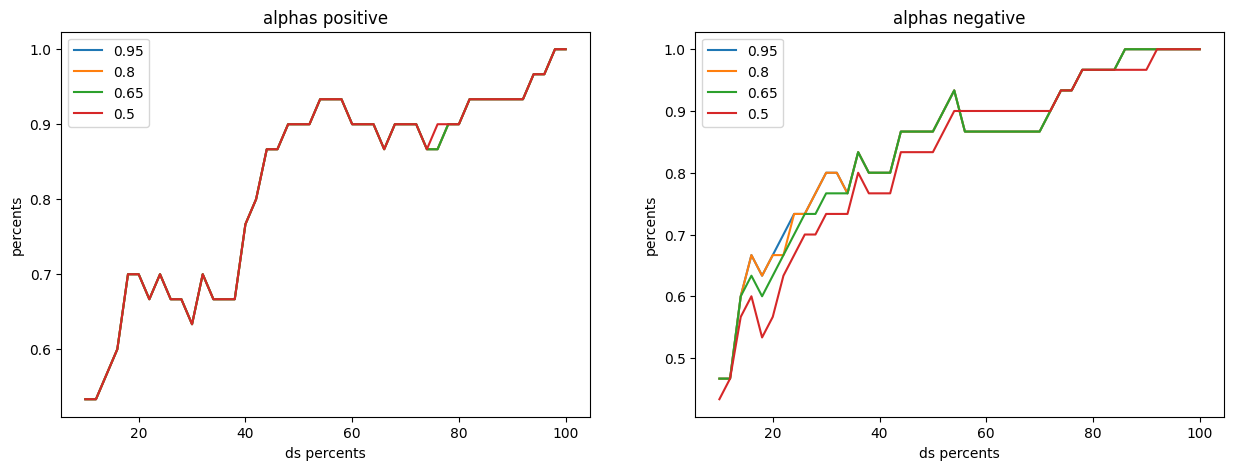

In [13]:
time_monitor()

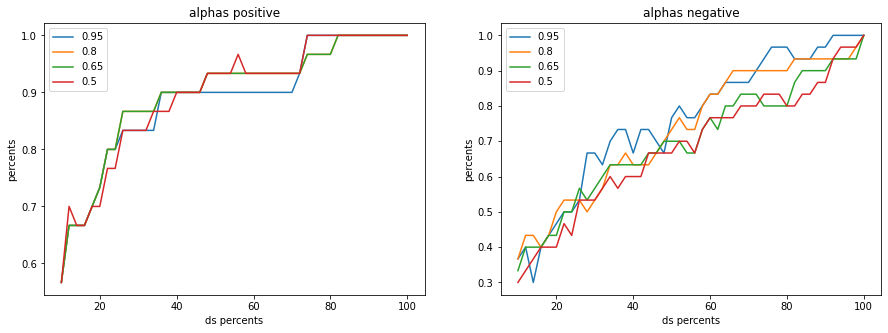

In [6]:
time_monitor()

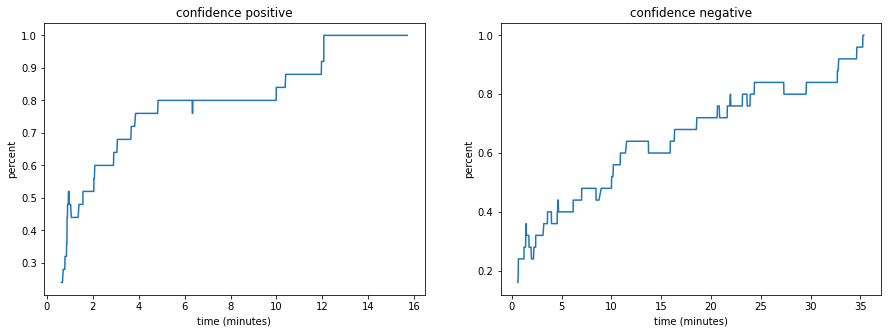

In [158]:
present_alpha_monitor()

In [196]:
def present_alpha_score_monitor(trail_path = 'topk', top = 25):
    """
    compare best topk negative and positive anchors scores between current result and the
    default running (without optimizations) top scores
    """
    pos_lines, neg_lines, pos_time, neg_time = get_results(f"{folder_name}/{trail_path}")

    alphas = [0.95, 0.8, 0.65, 0.5]
    
    for i, alpha in enumerate(alphas):     
        pos_scores, neg_scores, pos_max, neg_max = get_scores_dict(top, "0.1/scores.xlsx", alpha)
        
        pos_results = [sum(pos_scores.get(x, 0.0) for x in line) for line in pos_lines]
        neg_results = [sum(neg_scores.get(x, 0.0) for x in line) for line in neg_lines]
        
        plot(pos_time, pos_results, f'{sorting} {alpha} positive', neg_time, neg_results,
             f'{sorting} {alpha} negative', 'sum scores', pos_max, neg_max)

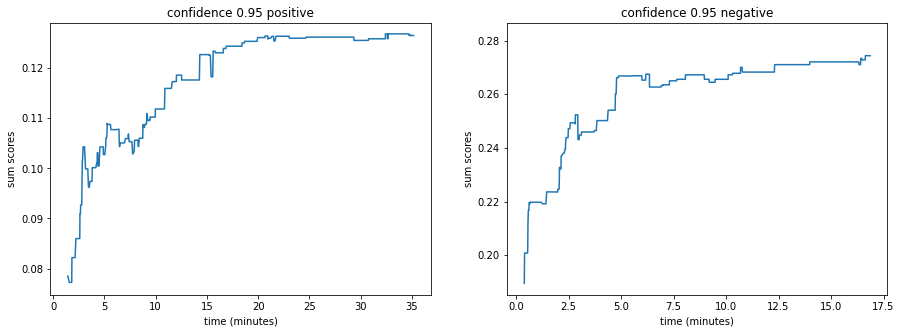

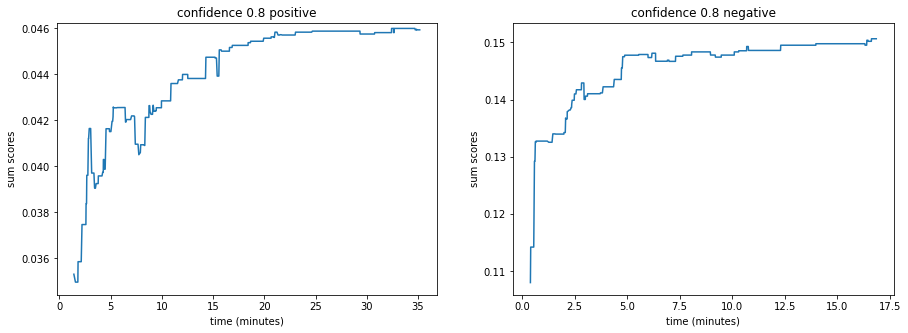

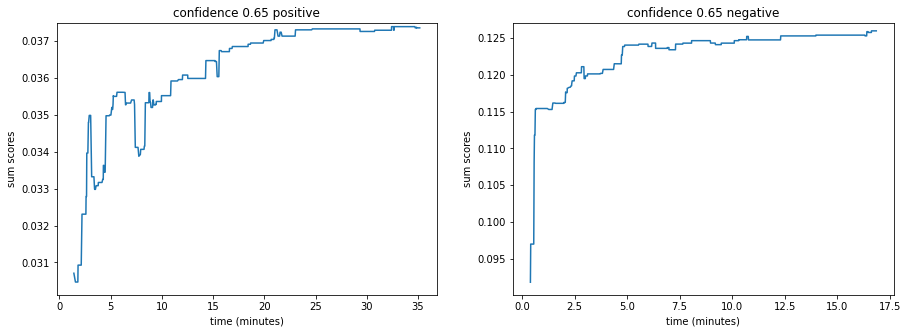

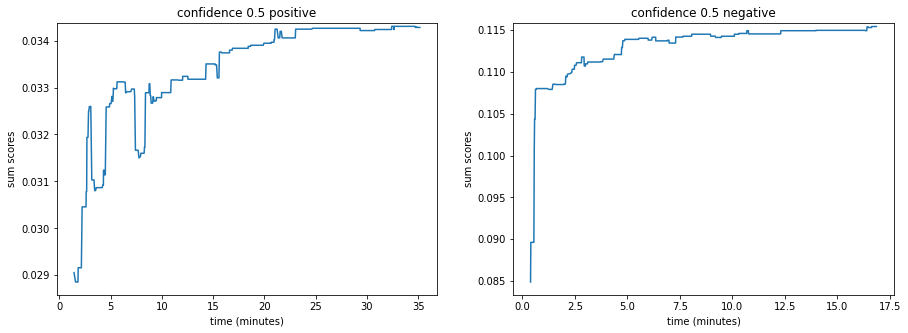

In [197]:
present_alpha_score_monitor()

In [198]:
def present_alpha_score_monitor_self(trail_path, top=25):
    """
    show changes of score along time (compared to itself and not to default)
    """
    pos_lines, neg_lines, pos_time, neg_time = get_results(f"{folder_name}/{trail_path}")

    alphas = [0.95, 0.8, 0.65, 0.5]
    
    for i, alpha in enumerate(alphas): 
        pos_scores, neg_scores, pos_max, neg_max = get_scores_dict(top, f"{trail_path}/scores.xlsx", alpha)
        
        pos_results = [sum(pos_scores.get(x, 0.0) for x in line) for line in pos_lines]
        neg_results = [sum(neg_scores.get(x, 0.0) for x in line) for line in neg_lines]
        
        plot(pos_time, pos_results, f'{sorting} {alpha} positive', neg_time, neg_results, 
             f'{sorting} {alpha} negative', 'sum scores', pos_max, neg_max)

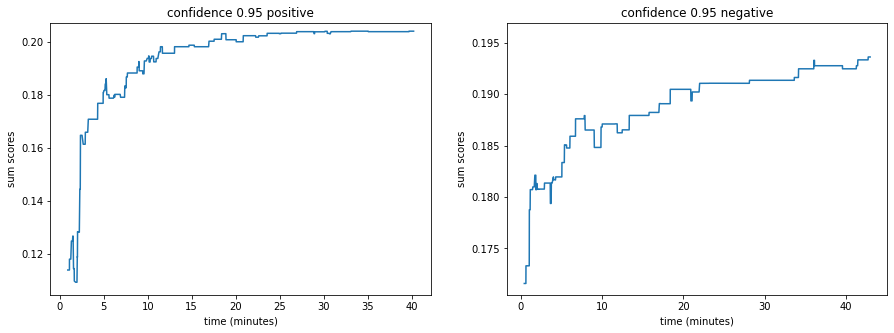

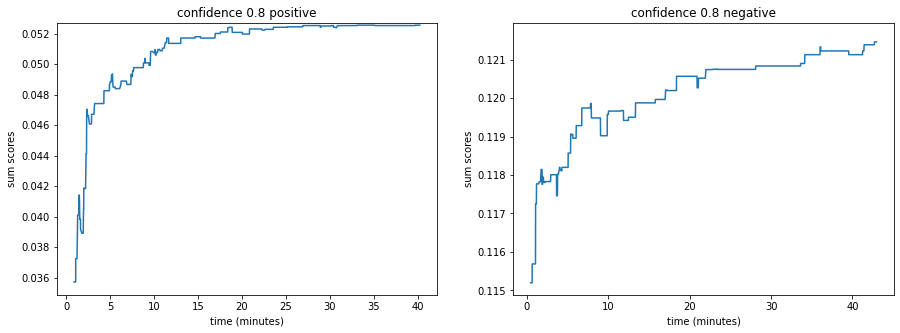

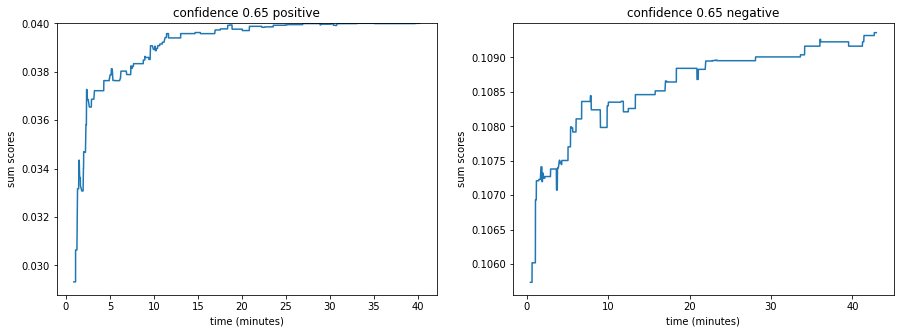

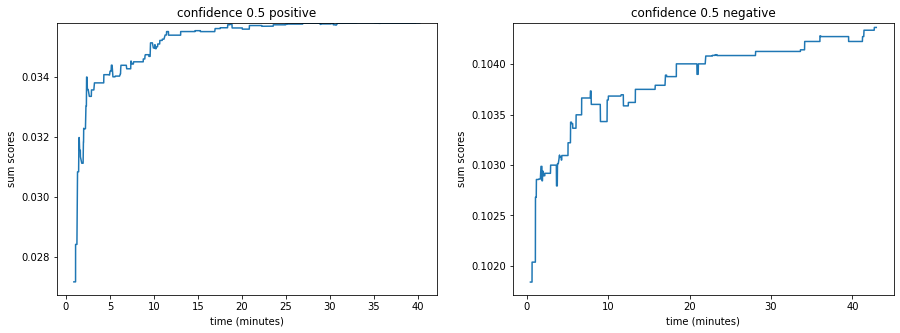

In [199]:
present_alpha_score_monitor_self('seed/168-shuffle')

In [192]:
from collections import defaultdict
    
def present_deltas_monitor(deltas, top=25):
    """ 
    compare final topk for different deltas to the default delta (0.1)
    """        
    default_pos, default_neg, default_pos_time, default_neg_time = get_results(f"{folder_name}/0.1")
    
    top_pos = set(default_pos[-1])
    top_neg = set(default_neg[-1])
    
    default_pos_results = [len(top_pos.intersection(set(line)))/top for line in default_pos]
    default_neg_results = [len(top_neg.intersection(set(line)))/top for line in default_neg]
    
    axs = plot(default_pos_time, default_pos_results, f'{dataset_name} {sorting} positive', default_neg_time, 
           default_neg_results, f'{dataset_name} {sorting} negative', 'percent', inside_label='default (0.1)')
    
    for delta in deltas:
        pos_lines, neg_lines, pos_time, neg_time = get_results(f'{folder_name}/{delta}')
        pos_delta_results = [len(top_pos.intersection(set(line)))/top for line in pos_lines]
        neg_delta_results = [len(top_neg.intersection(set(line)))/top for line in neg_lines]
        axs[0].plot(pos_time, pos_delta_results, label = str(delta))
        axs[1].plot(neg_time , neg_delta_results, label = str(delta))
        axs[0].legend()
        axs[1].legend()

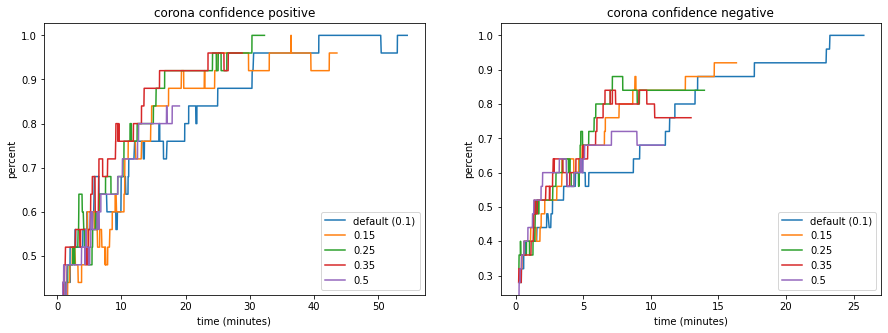

In [193]:
#deltas = [0.15, 0.20, 0.25, 0.3, 0.35, 0.5]
deltas = [0.15, 0.25, 0.35, 0.5]
present_deltas_monitor(deltas)

In [4]:
def present_deltas_score_monitor(deltas, top=25):
    """ 
    compare final topk score for different deltas to the default delta (0.1)
    """    
    pos_scores, neg_scores, pos_max, neg_max = get_scores_dict()
    default_pos, default_neg, default_pos_time, default_neg_time = get_results(f"{folder_name}/0.1")
    
    default_pos_scores = [sum(pos_scores.get(x, 0.0) for x in line) for line in default_pos]
    default_neg_scores = [sum(neg_scores.get(x, 0.0) for x in line) for line in default_neg]    
   
    axs = plot(default_pos_time, default_pos_scores, f'{dataset_name} {sorting} positive', default_neg_time, 
               default_neg_scores, f'{dataset_name} {sorting} negative', 'sum scores', pos_max, neg_max, 
               inside_label='default (0.1)')
    
    for delta in deltas:
        pos_lines, neg_lines, pos_time, neg_time = get_results(f'{folder_name}/{delta}')
        pos_delta_scores = [sum(pos_scores.get(x, 0.0) for x in line) for line in pos_lines]
        neg_delta_scores = [sum(neg_scores.get(x, 0.0) for x in line) for line in neg_lines]
        
        axs[0].plot(pos_time, pos_delta_scores, label = str(delta))
        axs[1].plot(neg_time , neg_delta_scores, label = str(delta))
        axs[0].legend()
        axs[1].legend()

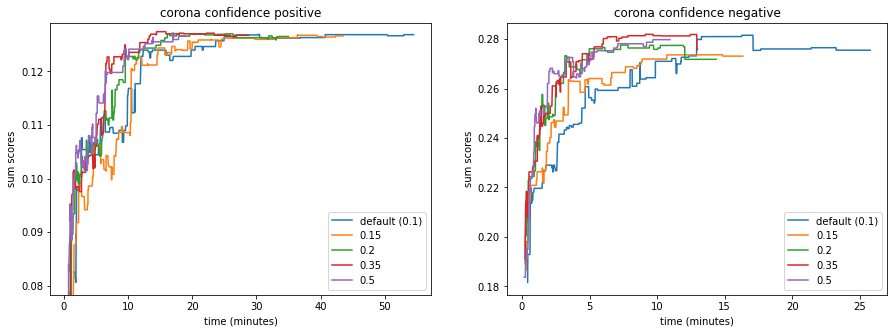

In [38]:
#deltas = [0.15, 0.20, 0.25, 0.3, 0.35, 0.5]
deltas = [0.15, 0.20, 0.35, 0.5]
present_deltas_score_monitor(deltas)

In [ ]:
def get_percents(pos_lines, pos_scores, expected_pos, neg_lines, neg_scores, expected_neg):
    pos_scores = [sum(pos_scores.get(x, 0.0) for x in line) for line in pos_lines]
    neg_scores = [sum(neg_scores.get(x, 0.0) for x in line) for line in neg_lines] 
    
    pos_percents = [100*val/expected_pos for val in pos_scores]
    neg_percents = [100*val/expected_neg for val in neg_scores]
    
    return pos_percents, neg_percents

In [110]:
def present_deltas_score_expectation_monitor(deltas, top=25):
    """ 
    compare final topk score for different deltas to the default delta (0.1),
    the y axis is the summed scores' percent of the expected 25 anchors' score
    the expected is sum of v^2 because the score is the same as the probability
    reasons higher than 100% is the sorting is good, or there are just a lot of low score anchors
    """    
    pos_scores, neg_scores, pos_max, neg_max = get_scores_dict()
    expected_pos = top*sum(v**2 for v in pos_scores.values())
    expected_neg = top*sum(v**2 for v in neg_scores.values())
    pos_max_percent = 100*pos_max/expected_pos
    neg_max_percent = 100*neg_max/expected_neg
    
    default_pos, default_neg, default_pos_time, default_neg_time = get_results(f"{folder_name}/0.1")
    default_pos_percents,  default_neg_percents = get_percents(default_pos, pos_scores, expected_pos, default_neg,
                                                              neg_scores, expected_neg) 
    
    axs = plot(default_pos_time, default_pos_percents, f'{dataset_name} {sorting} positive', default_neg_time, 
               default_neg_percents, f'{dataset_name} {sorting} negative', 'sum scores', pos_max_percent, 
               neg_max_percent, inside_label='default (0.1)')
    
    for delta in deltas:
        pos_lines, neg_lines, pos_time, neg_time = get_results(f'{folder_name}/{delta}')
        
        pos_delta_percents, neg_delta_percents = get_percents(pos_lines, pos_scores, expected_pos, neg_lines,
                                                              neg_scores, expected_neg)
        
        axs[0].plot(pos_time, pos_delta_percents, label = str(delta))
        axs[1].plot(neg_time , neg_delta_percents, label = str(delta))
        axs[0].legend()
        axs[1].legend()

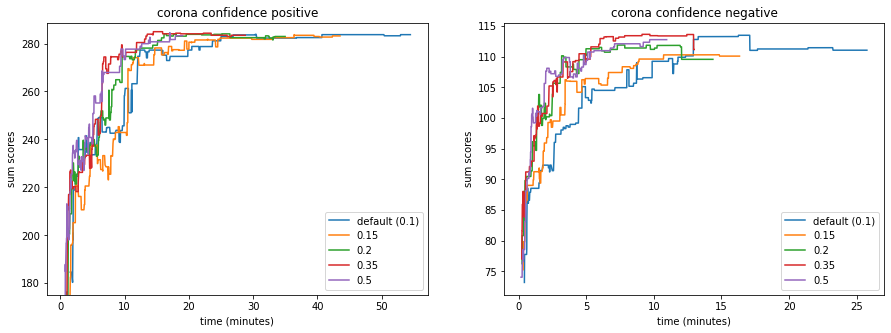

In [111]:
deltas = [0.15, 0.20, 0.35, 0.5]
present_deltas_score_expectation_monitor(deltas)

In [ ]:
def compare_seeds(seeds, top=25):
    """
    compare best negative and positive scores between different seeds (all without optimizations)
    """               
    alpha = 0.95
    dfs = [pd.read_excel(f'results/{dataset_name}/{sorting}/seed/{seed}/scores.xlsx').drop(0) for seed in seeds]
    pos_results, neg_results = [], []
    
    for seed1, df1 in zip(seeds, dfs):
        pos_percentages, neg_percentages = [seed1], [seed1]
        
        for seed2, df2 in zip(seeds, dfs): 
            pos_percentages.append(intersect_df(df1[f'{alpha}-positive'], df2[f'{alpha}-positive'], top))
            neg_percentages.append(intersect_df(df1[f'{alpha}-negative'], df2[f'{alpha}-negative'], top))     
        
        pos_results.append(pos_percentages)
        neg_results.append(neg_percentages)
    
    df_pos = pd.DataFrame(data = pos_results, columns = ['seed - positive']+seeds).set_index('seed - positive')
    df_neg = pd.DataFrame(data = neg_results, columns = ['seed - negative']+seeds).set_index('seed - negative')
    return df_pos, df_neg

In [ ]:
df_pos, df_neg = compare_seeds([42, 84, 126, 168])

In [ ]:
df_pos

In [ ]:
df_neg

In [ ]:
def compare_seeds_scores(seeds, top=25):
    """
    compare best negative and positive scores between different seeds (all without optimizations)
    """               
    alpha = 0.95
    dfs = [pd.read_excel(f'results/{dataset_name}/{sorting}/seed/{seed}/scores.xlsx').drop(0) for seed in seeds]
    pos_results, neg_results = [], []
    
    for seed1, df1 in zip(seeds, dfs):
        pos_percentages, neg_percentages = [seed1], [seed1]
        pos_scores, neg_scores, max_pos, max_neg = get_scores_dict(top, trail_path = f"seed/{seed1}/scores.xlsx")
        for seed2, df2 in zip(seeds, dfs): 
            df2_top = df2[f'{alpha}-positive'].head(top).tolist()
            df2_score = sum(pos_scores.get(x, 0.0) for x in df2_top)
            pos_percentages.append(max_pos - df2_score)
            
            df2_top = df2[f'{alpha}-negative'].head(top).tolist()
            df2_score = sum(neg_scores.get(x, 0.0) for x in df2_top)
            neg_percentages.append(max_neg - df2_score)
            
        pos_results.append(pos_percentages)
        neg_results.append(neg_percentages)
    
    df_pos = pd.DataFrame(data = pos_results, columns = ['seed - positive']+seeds).set_index('seed - positive')
    df_neg = pd.DataFrame(data = neg_results, columns = ['seed - negative']+seeds).set_index('seed - negative')
    return df_pos, df_neg

In [ ]:
df_pos, df_neg = compare_seeds_scores([42, 84, 126, 168])

In [ ]:
df_pos

In [ ]:
df_neg